In [251]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns
import pandas as pd
import math
from scipy.special import gammaln

In [252]:
encounters = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
frequencies = np.array([379, 299, 222, 145, 109, 95, 73, 59, 45, 30, 24, 12, 4, 2, 0, 1, 1])
N = frequencies.sum()
data = pd.DataFrame({
    'encounters': encounters,
    'frequencies': frequencies
})

<Axes: xlabel='encounters', ylabel='frequencies'>

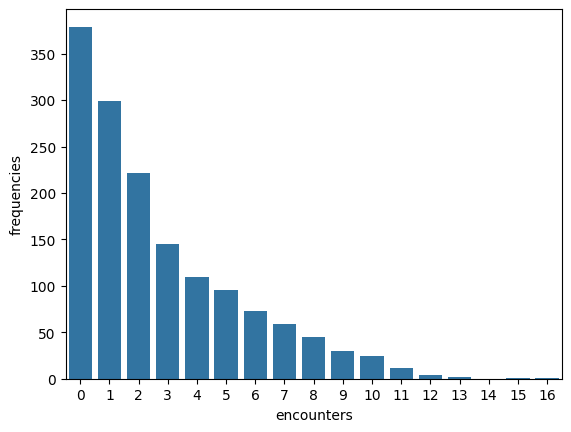

In [253]:
sns.barplot(x='encounters', y='frequencies', data=data)

In [254]:
# Initialize parameters
np.random.seed(42)
alpha = 0.3  # Probability of always reporting zero
beta = 0.4   # Probability of belonging to typical-risk group
mu = 3       # Mean of Poisson distribution for typical-risk group
lam = 8      # Mean of Poisson distribution for high-risk group

In [255]:
def poisson_pmf(x, mean):
    """ Compute Poisson probability mass function (PMF). """
    return (mean ** x) * np.exp(-mean) / math.factorial(x)

In [256]:
def e_step(encounters, frequencies, alpha, beta, mu, lam):
    """Expectation step: Compute responsibilities (posterior probabilities)."""
    responsibilities = np.zeros((len(encounters), 3))  # Columns: [Zero, Typical, High-Risk]

    for i in range(len(encounters)):
        x = encounters[i]

        # Compute probabilities for each group
        pi_zero = alpha if x == 0 else 0
        pi_typical = beta * poisson_pmf(x, mu)
        pi_high = (1 - alpha - beta) * poisson_pmf(x, lam)

        # Total probability for normalization
        total_prob = pi_zero + pi_typical + pi_high

        # Compute responsibilities
        responsibilities[i, 0] = pi_zero / total_prob if total_prob > 0 else 0  # Group Z
        responsibilities[i, 1] = pi_typical / total_prob if total_prob > 0 else 0  # Group T
        responsibilities[i, 2] = pi_high / total_prob if total_prob > 0 else 0  # Group P

    # Multiply by frequencies
    responsibilities *= frequencies[:, None]

    return responsibilities

In [257]:
def m_step(responsibilities, encounters):
    """Maximization step: Update parameters α, β, μ, λ."""
    Nk = np.sum(responsibilities, axis=0)  # Sum of responsibilities for each group
    N_total = np.sum(Nk)

    # Update parameters
    alpha_new = Nk[0] / N_total
    beta_new = Nk[1] / N_total
    mu_new = np.sum(responsibilities[:, 1] * encounters) / Nk[1]
    lam_new = np.sum(responsibilities[:, 2] * encounters) / Nk[2]

    return alpha_new, beta_new, mu_new, lam_new

In [258]:
def log_likelihood(encounters,frequencies, alpha, beta, mu, lambda_):
    
    log_likelihood = 0  # Initialize log-likelihood to negative infinity
    
    for i in range(len(encounters)):  # For each data point,
        pi_tetha= 0
        for k in range(3):  # For each group
            if k == 0:  # Zero encounters group
                pi_tetha += alpha 
            elif k == 1 or k==0 :  # Typical group (Poisson with mu)
                pi_k = beta
                poisson_val_bet= poisson.pmf(encounters[i], mu)
                # High-risk group (Poisson with lambda)
                pi_k = 1 - alpha - beta
                poisson_val_gam = poisson.pmf(encounters[i], lambda_)
                pi_tetha += beta * poisson_val_bet + (1 - alpha - beta) * poisson_val_gam
                
            # Compute the weighted log-likelihood
            log_likelihood += frequencies[i] * np.log(pi_tetha) -  gammaln(encounters[i] + 1)

    return log_likelihood

In [259]:
def em_algorithm(encounters, frequencies, alpha, beta, mu, lam, max_iterations=1000, tolerance=1e-6):
    """
    Implements the Expectation-Maximization (EM) algorithm for the Poisson Mixture Model.

    Args:
        encounters (np.array): Array of number of encounters (0 to 16).
        frequencies (np.array): Array of frequencies of encounters.
        alpha (float): Initial probability of the group with zero encounters.
        beta (float): Initial probability of the typical-risk group.
        mu (float): Initial parameter for the Poisson distribution of the typical-risk group.
        lam (float): Initial parameter for the Poisson distribution of the high-risk group.
        max_iterations (int): Maximum number of iterations to run the EM algorithm.
        tolerance (float): Convergence tolerance for the log-likelihood.

    Returns:
        (alpha, beta, mu, lam): Estimated parameters after convergence.
    """
    prev_likelihood = 0
    LK = []

    for iteration in range(max_iterations):
        # E-step: Calculate responsibilities (posterior probabilities for each group)
        responsibilities = e_step(encounters, frequencies, alpha, beta, mu, lam)

        # M-step: Update the parameters (alpha, beta, mu, lam)
        alpha_new, beta_new, mu_new, lam_new = m_step(responsibilities, encounters)

        # Compute the log-likelihood using the current responsibilities and parameters
        likelihood = log_likelihood(frequencies, encounters, alpha_new, beta_new, mu_new, lam_new)

        # Check for convergence based on the change in the log-likelihood
        if np.abs(likelihood - prev_likelihood) < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break

        # Update parameters for the next iteration
        alpha, beta, mu, lam = alpha_new, beta_new, mu_new, lam_new
        prev_likelihood = likelihood
        #store the log-likelihood values
        LK.append(likelihood)
    
    return alpha, beta, mu, lam, LK  # Return the estimated parameters and the log-likelihood values

In [260]:
responsabilities = e_step(encounters, frequencies, alpha, beta, mu, lam)

In [261]:
alpha, beta, mu, lam, LK = em_algorithm(encounters, frequencies, alpha, beta, mu, lam)

Converged at iteration 186


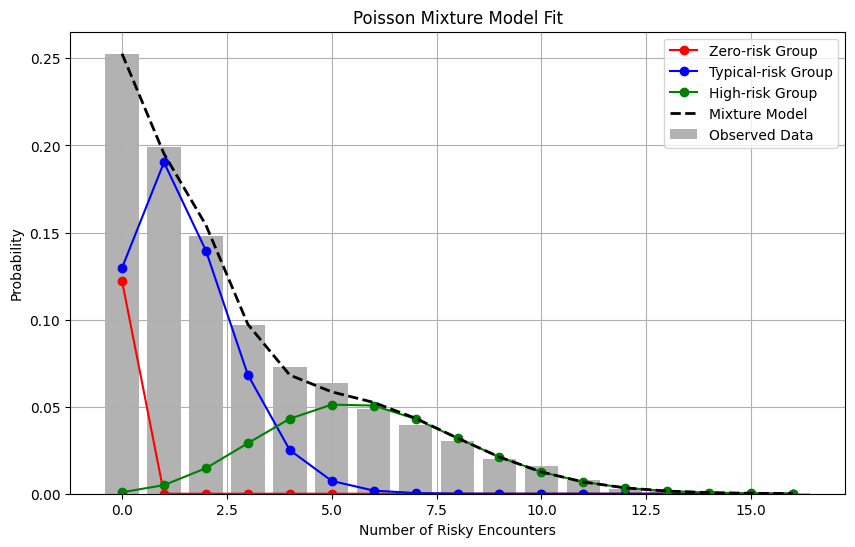

In [265]:
def plot_poisson_mixture(encounters, frequencies, alpha, beta, mu, lam):
    x = np.arange(0, max(encounters) + 1)
    
    # Compute Poisson PMFs
    poisson_zero = (x == 0).astype(float)  # Only nonzero at x = 0
    poisson_typical = poisson.pmf(x, mu)
    poisson_high_risk = poisson.pmf(x, lam)

    # Weighted contributions
    weighted_zero = alpha * poisson_zero
    weighted_typical = beta * poisson_typical
    weighted_high_risk = (1 - alpha - beta) * poisson_high_risk

    # Mixture distribution
    mixture_pmf = weighted_zero + weighted_typical + weighted_high_risk

    # Normalize frequencies for visualization
    normalized_frequencies = frequencies / np.sum(frequencies)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(encounters, normalized_frequencies, color='gray', alpha=0.6, label="Observed Data")
    plt.plot(x, weighted_zero, 'ro-', label="Zero-risk Group")
    plt.plot(x, weighted_typical, 'bo-', label="Typical-risk Group")
    plt.plot(x, weighted_high_risk, 'go-', label="High-risk Group")
    plt.plot(x, mixture_pmf, 'k--', label="Mixture Model", linewidth=2)

    plt.xlabel("Number of Risky Encounters")
    plt.ylabel("Probability")
    plt.title("Poisson Mixture Model Fit")
    plt.legend()
    plt.grid()
    plt.show()


plot_poisson_mixture(encounters, frequencies, alpha, beta, mu, lam)